<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/modeling_LeNet/test_sample_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install wget
! pip install datasets

In [ ]:
! rm -rf PyTorch-Architectures/
! git clone https://github.com/vishal-burman/PyTorch-Architectures.git

In [2]:
%cd PyTorch-Architectures/

/content/PyTorch-Architectures


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from modeling_LeNet.model import LeNet
from toolkit.custom_dataset_cv import DataLoaderCIFAR10Classification
from toolkit.utils import dict_to_device
from toolkit.trainer import Trainer

In [7]:
# Hyperparameters
INPUT_SIZE = 32
BATCH_SIZE = 128
LR = 0.001
EPOCHS = 10

In [8]:
train_loader = DataLoaderCIFAR10Classification(resize=INPUT_SIZE, train=True)
train_loader = train_loader.return_dataloader(batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoaderCIFAR10Classification(resize=INPUT_SIZE, train=False)
valid_loader = valid_loader.return_dataloader(batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of Train Loader --> {len(train_loader)}")
print(f"Length of Valid Loader --> {len(valid_loader)}")

cifar10 exists...
cifar10 exists...
Length of Train Loader --> 391
Length of Valid Loader --> 79


In [6]:
# Sanity check DataLoader
for sample in train_loader:
  assert sample["pixel_values"].dim() == 4
  assert sample["pixel_values"].size(2) == INPUT_SIZE
  break

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet(num_classes=10)
model.to(device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters --> {params}")

Trainable Parameters --> 548878


In [10]:
# Sanity check forward pass
model.eval()
with torch.set_grad_enabled(False):
  for sample in train_loader:
    loss, logits = model(**dict_to_device(sample, device=device))
    print(f"Loss --> {loss.item(): .2f}")
    print(f"Logits Shape --> {logits.shape}")
    break

Loss -->  2.31
Logits Shape --> torch.Size([128, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/3910 [00:00<?, ?it/s]

********** Running Training **********
  Total Training Steps = 3910  
  Epochs = 10  
  Batch Size = 128  
  Length of Train DataLoader = 391  
  Length of Valid DataLoader = 79  

Epoch: 1 || Training Loss: 1.451 || cv_accuracy: 54.140

Gradient-Flow for epoch 1


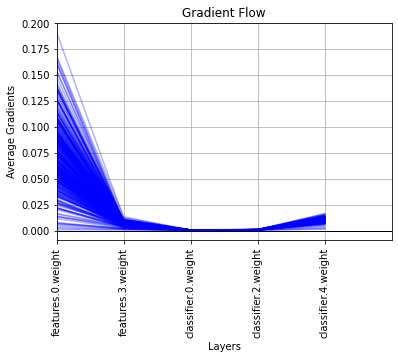


Epoch: 2 || Training Loss: 1.151 || cv_accuracy: 61.660

Gradient-Flow for epoch 2


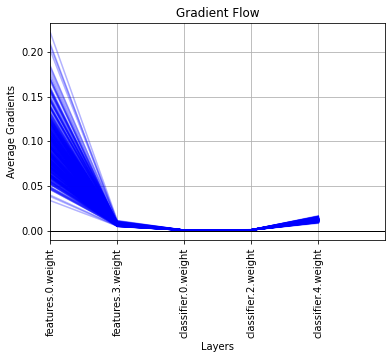


Epoch: 3 || Training Loss: 1.001 || cv_accuracy: 62.790

Gradient-Flow for epoch 3


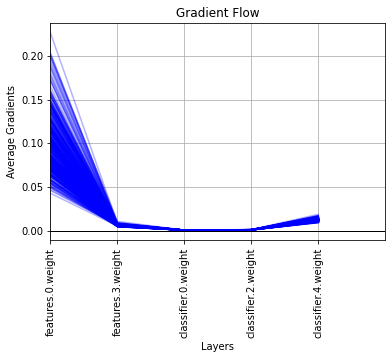


Epoch: 4 || Training Loss: 0.881 || cv_accuracy: 67.250

Gradient-Flow for epoch 4


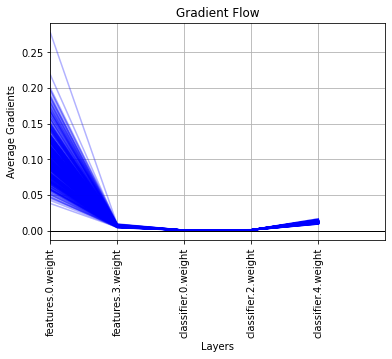


Epoch: 5 || Training Loss: 0.774 || cv_accuracy: 67.460

Gradient-Flow for epoch 5


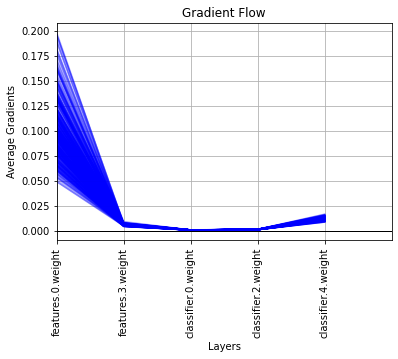


Epoch: 6 || Training Loss: 0.664 || cv_accuracy: 67.630

Gradient-Flow for epoch 6


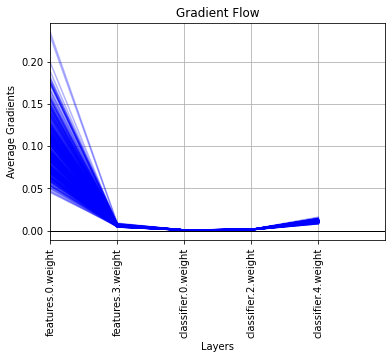


Epoch: 7 || Training Loss: 0.556 || cv_accuracy: 68.440

Gradient-Flow for epoch 7


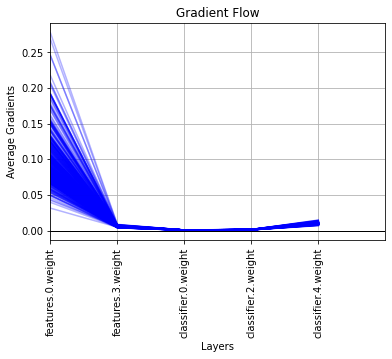


Epoch: 8 || Training Loss: 0.440 || cv_accuracy: 68.370

Gradient-Flow for epoch 8


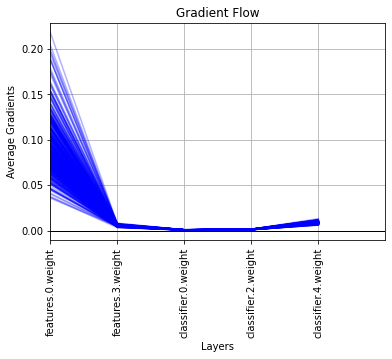


Epoch: 9 || Training Loss: 0.346 || cv_accuracy: 68.500

Gradient-Flow for epoch 9


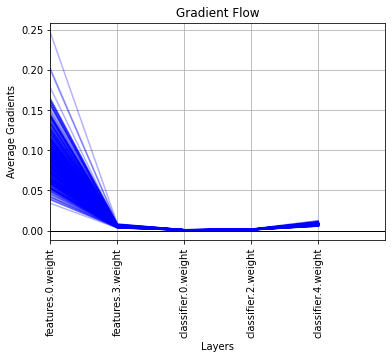


Epoch: 10 || Training Loss: 0.257 || cv_accuracy: 67.490

Gradient-Flow for epoch 10


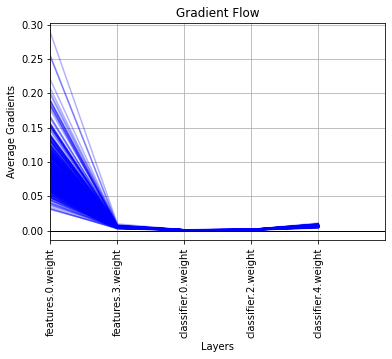

In [11]:
trainer = Trainer(model=model,
                  train_dataset=train_loader,
                  valid_dataset=valid_loader,
                  )
trainer.train(lr=LR, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              shuffle_train=True,
              scheduler=None,
              metric="cv_accuracy",
              show_grad_flow=True,
              )